In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from src.data.some_dataloader import RedditDataset
from src.utils.networkx_generator import *
from collections import Counter
from collections import defaultdict
from termcolor import cprint

## Load Data

In [3]:
dataset = RedditDataset()
data = dataset.data
body = dataset.data_body
title = dataset.data_title

To do the network analysis, we will create 3 different graphs. For all three graphs, nodes are subreddits and links are directed and represent hyperlinks.

- full: Here, the weight of the links represents the total number of hyperlinks
- positive: Here, the weight represents the number of positive
        minus the number of negative hyperlinks from one subreddit to another. We do not add links with weight < 1
- negative: Here, the weight represents the number of negative
        minus the number of positive hyperlinks from one subreddit to another. We do not add links with weight < 1

In [76]:
full_graphs = generate_graphs(data)

Generate the graphs
Run infomap on the graphs
  Infomap v2.8.0 starts at 2025-11-04 21:08:50
  -> Input network: 
  -> No file output!
  -> Configuration: directed
  OpenMP 201511 detected with 2 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'directed'... 
  -> Using unrecorded teleportation to links. 
  -> PageRank calculation done in 200 iterations.

  => Sum node flow: 1, sum link flow: 1
Build internal network with 67180 nodes and 339643 links...
  -> One-level codelength: 11.1509691

Trial 1/1 starting at 2025-11-04 21:08:51
Two-level compression: 22% 0.27% 
Partitioned to codelength 3.1281961 + 5.55547591 = 8.683672004 in 2564 (2510 non-trivial) modules.
Super-level compression: 0.0422741341% to codelength 8.680001057 in 720 top modules.

Recursive sub-structure compression: 0.910900577% 20.5641088% 0.018034338% 0.000133504229% 0% . Found 6 levels with codelength 8.683310542

=> Trial 

3it [00:00,  4.27it/s]


Add the attributes to the graphs
Export the graphs
G_full: nb nodes: 67180
G_full: nb edges: 339643
G_positive: nb nodes: 66848
G_positive: nb edges: 314501
G_negative: nb nodes: 56429
G_negative: nb edges: 19365


This first statistic looks at how well connected the graphs are. We see that while for the full graph and for the graph of positive interactions, more than 95\% of nodes are part of the main graph, this proportion goes down to ca. 15\% for the graph of negative interactions.

This shows that negative interactions are limited to a small subsets of subreddits.

In [180]:
print("Full graph: ", end="")
print_connected(full_graphs.full)
print("Graph of positive interactions: ", end="")
print_connected(full_graphs.positive)
print("Graph of negative interactions: ", end="")
print_connected(full_graphs.negative)

Full graph: 65648 out of 67180 nodes(97.719559%) are part of the main subgraph.
Graph of positive interactions: 64125 out of 66848 nodes(95.926580%) are part of the main subgraph.
Graph of negative interactions: 8332 out of 56429 nodes(14.765457%) are part of the main subgraph.


As for the further analysis, we are mostly intersted in the subreddits that are connected to the main graph (for the other subbredits there isn't much network analyis we can do), we will create 3 other graphs that are like the 3 graphs described above but only keeping the nodes that are connected to the main subgraph.

In [78]:
gs = extract_main_components(full_graphs)

## Analysis of communities

We want to analyze the graph

In [ ]:
neg_weighted_in_degree = dict(gs.negative.in_degree(weight='weight'))
neg_weighted_out_degree = dict(gs.negative.out_degree(weight='weight'))
full_weighted_in_degree = dict(gs.full.in_degree(weight='weight'))
full_weighted_out_degree = dict(gs.full.out_degree(weight='weight'))

# Group nodes by community
communities: defaultdict[str, list[str]] = defaultdict(list)
for node, comm in gs.louvain_neg.items():
    communities[f"Community with id {comm}"].append(node)
communities["Graph of negative hyperlinks"] = gs.negative.nodes()

sorted_communities = sorted(communities.items(), key=lambda item: len(item[1]), reverse=True)

Here, we print the communities that attack the most and communities that are the most attacked, for the whole graph and for the biggest communities detected by the louvain algorithm.

We see that some very big subreddits like "bestof" start a big number of attacks simply because of the size of the subreddit, even though only a very small proportion of all posts start negative interactions.

We then have subreddits where most of the hyperlinks are posted with negative sentiment. But these subreddits are much smaller.

Further analyses could include measuring the "betweenness centrality" to see if there exist any subreddit with a high proportion of negative hyperlinks that is also structurally important for the network (high betweenness centrality).

In [187]:
def top_degrees(nodes: list[str]):

    top_nodes_in_degree = sorted(nodes, key=lambda n: neg_weighted_in_degree.get(n, 0), reverse=True)[:5]
    top_nodes_out_degree = sorted(nodes, key=lambda n: neg_weighted_out_degree.get(n, 0), reverse=True)[:5]
    
    cprint(f"Nodes that attack the most (highest out degree):", color="blue")
    for node in top_nodes_out_degree:
        print(f"{node:<22}: {neg_weighted_out_degree.get(node, 0):>3} out of {full_weighted_out_degree.get(node, 0):>6,} "
              f"hyperlinks ({(neg_weighted_out_degree.get(node, 0)/full_weighted_out_degree.get(node, 0))*100:.2f}%)")
    cprint(f"Nodes that are the most attacked (highest in degree):", color="blue")
    for node in top_nodes_in_degree:
        print(f"{node:<22}: {neg_weighted_in_degree.get(node, 0):>3} out of {full_weighted_in_degree.get(node, 0):>6,} "
              f"hyperlinks ({(neg_weighted_in_degree.get(node, 0)/full_weighted_in_degree.get(node, 0))*100:.2f}%)")
    
    top_nodes_in_degree = sorted(nodes, key=lambda n: (neg_weighted_in_degree[n] / full_weighted_in_degree[n]) if full_weighted_in_degree[n] > 20 else 0, reverse=True)[:5]
    top_nodes_out_degree = sorted(nodes, key=lambda n: (neg_weighted_out_degree[n] / full_weighted_out_degree[n]) if full_weighted_out_degree[n] > 20 else 0, reverse=True)[:5]
    
    cprint(f"Nodes with a degree > 20 that have the highest attack vs cite ratio:", color="blue")
    for node in top_nodes_out_degree:
        print(f"{node:<22}: {neg_weighted_out_degree.get(node, 0):>3} out of {full_weighted_out_degree.get(node, 0):>6,} "
              f"hyperlinks ({(neg_weighted_out_degree.get(node, 0)/full_weighted_out_degree.get(node, 0))*100:.2f}%)")
    cprint(f"Nodes with a degree > 20 that have the highest being attacked vs being cited ratio :", color="blue")
    for node in top_nodes_in_degree:
        print(f"{node:<22}: {neg_weighted_in_degree.get(node, 0):>3} out of {full_weighted_in_degree.get(node, 0):>6,} "
              f"hyperlinks ({(neg_weighted_in_degree.get(node, 0)/full_weighted_in_degree.get(node, 0))*100:.2f}%)")

In [ ]:
for name, nodes in sorted_communities[:9]:
    cprint(f"{name} ({len(nodes)} nodes)", "green")
    top_degrees(nodes)

Graph of negative hyperlinks (8332 nodes)
Nodes that attack the most (highest out degree):
subredditdrama        : 801 out of 27,636 hyperlinks (2.90%)
drama                 : 609 out of  6,784 hyperlinks (8.98%)
bestof                : 291 out of 21,170 hyperlinks (1.37%)
botsrights            : 233 out of  2,314 hyperlinks (10.07%)
circlebroke2          : 163 out of  6,583 hyperlinks (2.48%)
Nodes that are the most attacked (highest in degree):
askreddit             : 347 out of 26,622 hyperlinks (1.30%)
news                  : 247 out of  7,692 hyperlinks (3.21%)
funny                 : 226 out of 10,777 hyperlinks (2.10%)
videos                : 194 out of 10,013 hyperlinks (1.94%)
worldnews             : 185 out of  9,944 hyperlinks (1.86%)
Nodes with a degree > 20 that have the highest attack vs cite ratio:
topcuntsofreddit      :  21 out of     25 hyperlinks (84.00%)
sjwnews               :  77 out of    123 hyperlinks (62.60%)
deadpoolhatersclub    :  51 out of     82 hyperlink

Here we measure the in-degree and out-degree distribution of the full network, of the network of negative hyperlinks, and of the biggest community. They all seem to follow a similar scale free distribution.

Full Graph (65648 nodes)
Graph of negative hyperlinks (8332 nodes)
Community with id 2 (595 nodes)


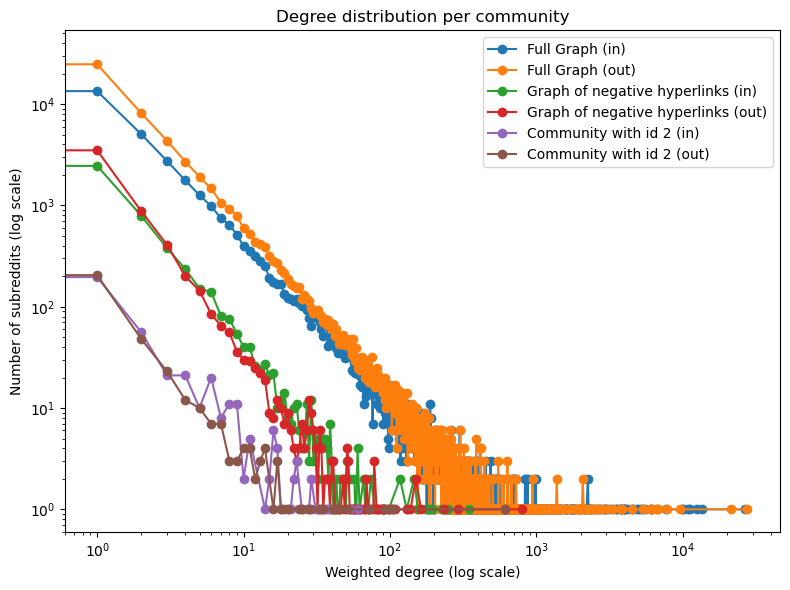

In [186]:


plt.figure(figsize=(8,6))
# Print top 5 nodes by weighted degree for each community
for name, nodes in [("Full Graph", gs.full.nodes())] + sorted_communities[:2]:
    cprint(f"{name} ({len(nodes)} nodes)", "green")

    # In degrees
    degrees = [neg_weighted_in_degree.get(node, 0) for node in nodes]
    if name == "Full Graph":
        degrees = [full_weighted_in_degree.get(node, 0) for node in nodes]
    degree_counts = Counter(degrees)
    x = sorted(degree_counts.keys())
    y = [degree_counts[d] for d in x]
    plt.plot(x, y, marker='o', linestyle='-', label=f'{name} (in)')

    # Out degrees
    degrees = [neg_weighted_out_degree.get(node, 0) for node in nodes]
    if name == "Full Graph":
        degrees = [full_weighted_out_degree.get(node, 0) for node in nodes]
    degree_counts = Counter(degrees)
    x = sorted(degree_counts.keys())
    y = [degree_counts[d] for d in x]
    plt.plot(x, y, marker='o', linestyle='-', label=f'{name} (out)')
    
# Log–log scale
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Weighted degree (log scale)')
plt.ylabel('Number of subreddits (log scale)')
plt.title('Degree distribution per community')
plt.legend()
plt.tight_layout()
plt.show()